In [127]:
import numpy as onp
from functools import partial
import jax.numpy as np
from jax import random
from jax import jit, vmap
from jax_md.util import *
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax_md import quantity, energy

from jax_pd import space, materials, damage, mesh, plots, solvers, util


In [128]:
displacement_fn, shift_fn = space.free()

R = np.array([[i,j,k] for i in range(6) for j in range(10) for k in range(1)],dtype=np.float32)

box_size = [10,10,9]
cutoff = f32(2.5)

bonds = util.bonds(displacement_fn, box_size, cutoff, R)

/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4547: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4547: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4547: 

In [129]:
lengths0 = util.bond_lengths(bonds,R)
bonds.shape


(474, 2)

In [130]:
energy_fn = [{'func':materials.simple_spring_bond,
              'args':[displacement_fn], 
              'kwargs':dict(bond=bonds,length=lengths0, epsilon=f32(100), stretch=f32(0.1), radius=f32(1.0))
                 }, 
            {'func':energy.soft_sphere_pair, 
             'args':[displacement_fn], 
             'kwargs':dict(sigma=f32(1.0), epsilon=f32(1000.0))
                },
                [bonds,f32(0.1)]]

def cal_energy(R,energy_fn):
    energy_fn_calable = [i['func'](*i['args'],**i['kwargs']) for i in energy_fn[:-1]]
    return np.sum([j(R) for j in energy_fn_calable])

cal_energy(R,energy_fn)

DeviceArray(0., dtype=float32)

In [131]:
def move(R,bool,t=0,R0=R,v=np.array([[0.01,0,0]])):
    return R0[bool,:]+t*v

def fix(R,bool,t=0,R0=R):
    return R0[bool,:]


Rbc = [{'bool':(R[:,0]<1.5)&(R[:,1]<4),'fn':move,'kwargs':{'R0':R,'v':np.array([[-0.001,0,0]])}},
       {'bool':(R[:,0]>3.5)&(R[:,1]<4),'fn':move,'kwargs':{'R0':R,'v':np.array([[0.001,0,0]])}},
              ]

# Rbc = []

# iVbc = [{'bool':R[:,0]>7.5,'fn':fix,'kwargs':{'R0':R*0-np.array([[0,0,1]])}},
#        {'bool':(R[:,0]>2.5) & (R[:,0]<6.5),'fn':fix,'kwargs':{'R0':R*0-np.array([[0,0,-1]])}},
#        {'bool':R[:,0]<1.5,'fn':fix,'kwargs':{'R0':R*0-np.array([[0,0,1]])}},
#        ]


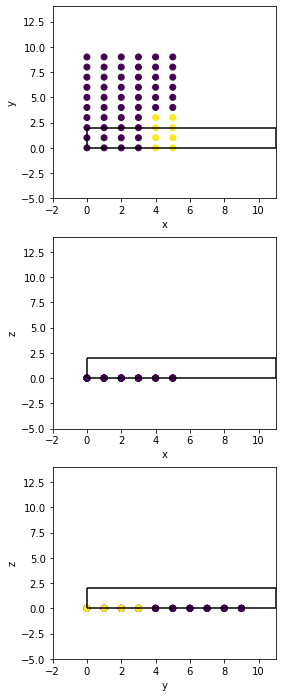

In [132]:
R1 = [R]

def Plotit(i):
    x,y = 1,3
    fig, axs = plt.subplots(y,x,figsize=[4*x,4*y])
    labels = [['x','y'],['x','z'],['y','z']]
    for ax,label in zip(axs,labels):
        ax.set_xlim([-2, 11])
        ax.set_ylim([-5, 14])
        ax.hlines(0,0,11)
        ax.hlines(2,0,11)
        ax.vlines(0,0,2)
        ax.vlines(11,0,2)
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.axis('on')

    plots.W3(i,R1,axs,c=(Rbc[1]['bool']).astype(int))
    plt.show()

Plotit(0)


In [133]:
R1 = [R]
runs = 1000
R2, state_values, states = solvers.run_simulation(key,runs,1.0e-3, R,energy_fn,shift_fn,Rbc=Rbc,mass=1.0,print_every=20,value_every=3,pos_every=1)

R1 += R2

Initial conditions(after iBC): 
KE: 0.000000, PE: 0.000, TE: 0.000
Initial conditions(after BC): 
KE: 0.000000, PE: 0.000, TE: 0.000
Run # 0 :  KE: 0.000000, PE: 0.000, TE: 0.000
Run # 20 :  KE: 0.054317, PE: 1.218, TE: 1.272
Run # 40 :  KE: 0.915199, PE: 4.729, TE: 5.644
Run # 60 :  KE: 4.455534, PE: 10.294, TE: 14.749
Run # 80 :  KE: 13.256500, PE: 17.915, TE: 31.171
Run # 100 :  KE: 30.572943, PE: 27.788, TE: 58.361
Run # 120 :  KE: 60.704609, PE: 39.988, TE: 100.693
Run # 140 :  KE: 106.706123, PE: 49.748, TE: 156.454
Run # 160 :  KE: 169.840607, PE: 60.415, TE: 230.256
Run # 180 :  KE: 249.327225, PE: 67.477, TE: 316.804
Run # 200 :  KE: 344.600342, PE: 76.547, TE: 421.148
Run # 220 :  KE: 452.217133, PE: 62.779, TE: 514.996
Run # 240 :  KE: 553.765137, PE: 61.340, TE: 615.105
Run # 260 :  KE: 655.897766, PE: 49.807, TE: 705.705
Run # 280 :  KE: 746.346252, PE: 43.108, TE: 789.454
Run # 300 :  KE: 819.856750, PE: 40.541, TE: 860.397
Run # 320 :  KE: 861.289490, PE: 40.601, TE: 901

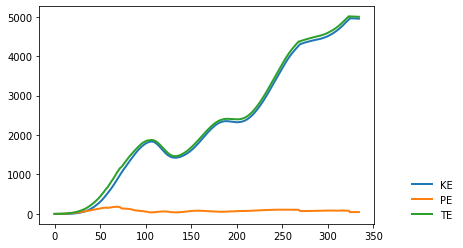

In [92]:
plt.plot(range(len(state_values)),np.array(state_values),lw=2)
plt.legend(['KE','PE','TE'],frameon=False,loc=[1.1,0])

In [117]:
F1 = []
F2 = []
mask1 = Rbc[0]['bool']
mask2 = Rbc[1]['bool']


F1 += [(st.acceleration[mask1,0]*st.mass).sum() for st in state]
F2 += [(st.acceleration[mask2,0]*st.mass).sum() for st in state]
    

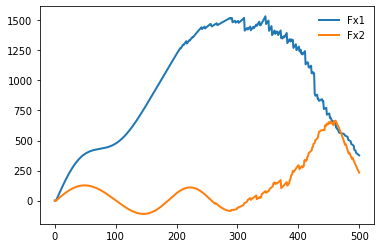

In [118]:
plt.plot(range(len(F1)),F1,label='Fx1',lw=2)
plt.plot(range(len(F2)),F2,label='Fx2',lw=2)
plt.legend(frameon=0)

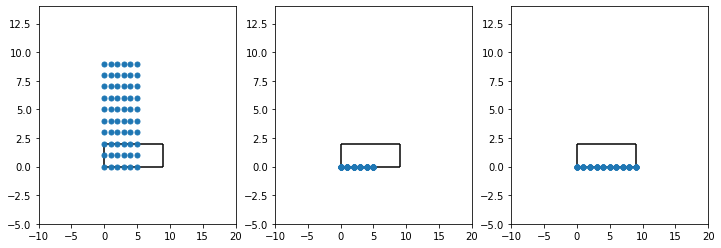

In [97]:
from IPython.display import display

import matplotlib
k = 50
ms = 5


def myplot(i):
    global ax,l,k
    i = i*k
    R_plt = onp.array(R1[i])
    ls[0].set_data(R_plt[:, 0], R_plt[:, 1],) 
    ls[1].set_data(R_plt[:, 0], R_plt[:, 2],) 
    ls[2].set_data(R_plt[:, 1], R_plt[:, 2],) 


fig, axs = plt.subplots(1,3,figsize=[12,4])
ls = []
for ax in axs:
    ls.append(ax.plot([],[],'o', markersize=ms)[0])
    ax.set_xlim([-10, 20])
    ax.set_ylim([-5, 14])
    ax.hlines(0,0,9)
    ax.hlines(2,0,9)
    ax.vlines(0,0,2)
    ax.vlines(9,0,2)
    ax.axis('on')


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, myplot, frames=int(len(R1)/k))

from IPython.display import HTML
_ = HTML(ani.to_jshtml())


In [98]:
display(_)

In [123]:
skip = 1
with open('./tensile_bar.xyz','w+') as f:
    for i in range(int(len(R1)/skip)):
        r = R1[i*skip]
        f.write(str(len(r))+'\n\n')        
        for i in r:
            f.write('{} {} {}\n'.format(*i))
print(int(len(R1)/skip))

1
